In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from scipy.stats import uniform

%matplotlib inline

In [4]:
import sys
sys.path.append('../pop_synth')
import pop_synth
sys.path.append('../binary')
import binary_evolve
import load_sse
import corner
import pickle

load_sse.load_sse()

### Constants

In [3]:
GGG = 1.909e5 # Gravitational constant in Rsun * (km/s)^2 / Msun
km_to_cm = 1.0e5 # km to cm
Msun_to_g = 1.989e33 # Msun to g
Rsun_to_cm = 6.995e10 # Rsun to cm
pc_to_km = 3.086e13 # pc to km
yr_to_sec = 31557600.0 # Sec in yr
Myr_to_yr = 1.0e6 # yr in Myr

M_0 = 0.073 # in Msun
xi = 0.704
M_NS = 1.35
v_wind = 1000.0 # companion velocity in km/s
R_NS = 12.0  # NS radius in km
Dist_LMC = 5.0e4 * pc_to_km # in km
eta_bol = 0.3  # Conversion from bolometric to X-ray luminosity

### Load SSE data

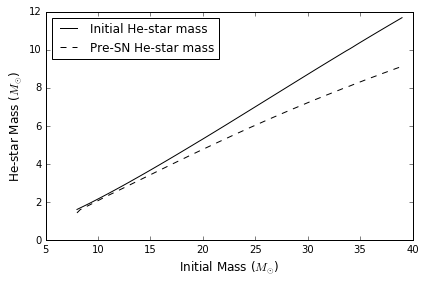

In [4]:
He_mass = np.array([])
masses = np.linspace(8.0, 39.0, 100)


he_star_initial = load_sse.func_sse_he_mass(masses)
he_star_final = load_sse.func_sse_he_star_final(he_star_initial)

plt.plot(masses, he_star_initial, color='k', linestyle='solid', label='Initial He-star mass')
plt.plot(masses, he_star_final, color='k', linestyle='dashed', label='Pre-SN He-star mass')

plt.legend(loc=2)

plt.xlabel(r'Initial Mass ($M_{\odot}$)', fontsize=12)
plt.ylabel(r'He-star Mass ($M_{\odot}$)', fontsize=12)

plt.tight_layout()
plt.savefig('../figures/He_star_masses.pdf')
#plt.show()

In [18]:
print load_sse.func_sse_ms_time(13.0)
print load_sse.func_sse_tmax(13.0)

15.8038177
17.7565174


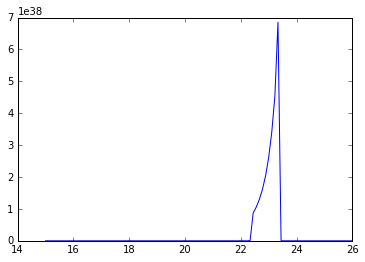

In [24]:
M1 = 13.0
M2 = 10.0
A = 100.0
ecc = 0.3
v_k = 250.0
theta = 2.9
phi = 0.9
t_obs = 22.0


t_obs = np.linspace(15.0, 26.0, 100)
L_x = np.array([])

for t in t_obs:
    out = pop_synth.full_forward(M1, M2, A, ecc, v_k, theta, phi, t)
    L_x = np.append(L_x, out[2])
    
plt.plot(t_obs, L_x)
plt.show()

In [ ]:
xmin = 0.0
xmax = 140.0

for i in np.arange(len(func_sse_tmax)):
    temp_x = np.linspace(1.0, min(func_sse_tmax[i], xmax), 2000)
    temp_y = func_sse_mdot[i](temp_x)

    plt.plot(temp_x, temp_y)
    
plt.xlim(xmin, xmax)

plt.xlabel("Time (Myr)")
plt.ylabel("Mass loss rate (Msun/yr)")

plt.text(35.0, 1.7e-4, r"M$_i = $8.1 M$_{\odot}$")

plt.show()

In [ ]:
# Let's test out one model, just to see how the above aggregate plot is put together

# Pick the index for a 7 Msun model
i = 3500
print "Initial mass = ", func_sse_mass[i](0.0)

temp_x = np.linspace(1.0, min(func_sse_tmax[i], xmax), 2000)
temp_y = func_sse_mdot[i](temp_x)

plt.plot(temp_x, temp_y)
    
# Same x,y limits as previous plot
plt.xlim(xmin, xmax)
plt.ylim(0.0,3.0e-4)

plt.xlabel("Time (Myr)")
plt.ylabel("Mass loss rate (Msun/yr)")

plt.show()

In [ ]:
xmin = 0.0
xmax = 140.0

for i in np.arange(len(func_sse_tmax)):
    temp_x = np.linspace(1.0, min(func_sse_tmax[i], xmax), 100)
    temp_y = func_sse_mass[i](temp_x)

    plt.plot(temp_x, temp_y)
    
plt.xlim(xmin, xmax)

plt.xlabel("Time (Myr)")
plt.ylabel("Mass (Msun)")

plt.show()

In [ ]:

#for i in np.arange(1):
#     temp_x = np.linspace(1.0, func_sse_tmax[i], 1000)
#     temp_y = func_sse_mass[i](temp_x)
#     temp_z = func_sse_mdot[i](temp_x)
    
#     plt.plot(temp_y, temp_z)
    
i = 1000    
temp_x = np.linspace(1.0, func_sse_tmax[i], 1000)
plt.plot(func_sse_mass[i](temp_x), func_sse_mdot[i](temp_x))

    
#plt.xlim(0.0, 2.0)

plt.xlabel("Mass (Msun)")
plt.ylabel("Mass loss rate (Msun/yr)")

plt.show()

In [ ]:
def func_get_sse_star(mass, time):
        
    tmp = int(mass*100.0)-100

    if ((tmp < 0) or (tmp>len(func_sse_mass))): return -1
    
    return func_sse_mass[tmp](time), func_sse_mdot[tmp](time)
    
    

### The X-ray wind accreting phase

In [ ]:
def func_Lx_forward(M_2_in, A_in, t_obs):
    
    # Interpolate SSE data to get M_2, Mdot_2
    M_2_out, M_dot_wind = func_get_sse_star(M_2_in, t_obs)
        
    # Get final orbital separation
    A_out = (M_NS + M_2_in) / (M_NS + M_2_out) * A_in
    
    M_dot_out = (GGG*M_NS / (v_wind*v_wind*A_out))**2 * M_dot_wind
    
    L_bol = GGG * M_NS * M_dot_out / R_NS * km_to_cm * Msun_to_g * Rsun_to_cm / yr_to_sec
    L_x = L_bol
    return L_x
    
    

In [ ]:
# Pick the index for a 10 Msun model
mass = 10.0
tmp = int(mass*100.0)-100

print "Initial mass = ", func_sse_mass[tmp](0.0)

temp_x = np.linspace(1.0, min(func_sse_tmax[tmp], xmax), 2000)
temp_y = func_sse_mdot[tmp](temp_x)

plt.plot(temp_x, temp_y)
    
# Same x,y limits as previous plot
#plt.xlim(xmin, xmax)
plt.ylim(1.0e-9,3.0e-6)

plt.yscale('log')

plt.xlabel("Time (Myr)")
plt.ylabel("log Mass loss rate (Msun/yr)")

plt.show()

In [ ]:
# Let's test some values here
A_test = 10.0 ** np.linspace(2.0, 3.2, 100)

plt.plot(A_test, func_Lx_forward(10.0, A_test, 10.0), label='10 Myr')
plt.plot(A_test, func_Lx_forward(10.0, A_test, 15.0), label='15 Myr')
plt.plot(A_test, func_Lx_forward(10.0, A_test, 20.0), label='20 Myr')
plt.plot(A_test, func_Lx_forward(10.0, A_test, 25.0), label='25 Myr')

plt.yscale('log')

plt.xlabel(r"Orbital Separation (R$_{\odot}$)")
plt.ylabel(r"log L (erg s$^{-1}$)")

plt.legend()

plt.show()

## Now, let's test the Jacobians

First, some math. 

Bayes' Theorem:
$$ P(M | D, I) = \frac{P(D | M, I) P(M | I)}{P(D | I)}. $$
Now, we want to find the likelihood $P(D | M, I)$, where:
$$ D = \{\alpha, \delta, \vec{m}, L_x\}$$
and
$$ M = \{ M_1, M_2, a, v_k, \theta, \phi, t_b, \alpha_b, \delta_b \}.$$

First, we marginalize over 8 separate parameters:
$$ P(D | M, I) = \int {\rm d}M_2''\ {\rm d}A'''\ {\rm d}t'\ {\rm d}t_{\rm sn}\ {\rm d}v_{\rm sys}\ {\rm d}\theta_{\rm proj}\ {\rm d}\omega\ {\rm d}\phi$$
$$ \times\ P(\alpha, \delta, \vec{m}, L_x, M_2'', A''', t', t_{\rm sn}, v_{\rm sys}, \theta_{\rm proj}, \omega, \phi\ |\ M_1, M_2, a, v_k, \theta, \phi, t_b, \alpha_b, \delta_b, I).$$

Now we can separate independent terms:
$$ P(D | M, I) = \int {\rm d}M_2''\ {\rm d}A'''\ {\rm d}t'\ {\rm d}v_{\rm sys}$$
$$ \times\ P( \vec{m}\ |\ M_2'', t', I )$$
$$ \times\ P( L_x\ |\ M_2'', A''', t', I )$$
$$ \times\ P( M_2'', A'', t', v_{\rm sys}\ |\ M_1, M_2, t_b, A, v_k, \theta, \phi, I )$$
$$ \times\ \int {\rm d}t_{\rm sn}\ {\rm d}\theta_{\rm proj}\ {\rm d}\omega\ {\rm d}\phi\  
P(\alpha, \delta, \theta_{\rm proj}, \omega, \phi, t_{\rm sn} |\ \alpha_b, \delta_b, v_{\rm sys}, t_b, M_1, I )$$

We will define and address each of these terms independently.

### $\int {\rm d}t_{\rm sn}\ {\rm d}\theta_{\rm proj}\ {\rm d}\omega\ {\rm d}\phi\  
P(\alpha, \delta, \theta_{\rm proj}, \omega, \phi, t_{\rm sn} |\ \alpha_b, \delta_b, v_{\rm sys}, t_b, M_1, I )$

We'll start with the innermost set of integrals. This term defines the position of the HMXB today, as a function of the system's birth place, systemic velocity, and time since the primary collapsed in a SN. We first want to separate terms:
$$
\int {\rm d}t_{\rm sn}\ {\rm d}\theta_{\rm proj}\ {\rm d}\omega\ {\rm d}\phi\  
P(\alpha, \delta, \theta_{\rm proj}, \omega, \phi, t_{\rm sn} |\ \alpha_b, \delta_b, v_{\rm sys}, t_b, M_1, I ) \\
 = \int\ {\rm d}t_{\rm sn}\ P(t_{\rm sn} | t_b, M_1, I)\ 
 \int {\rm d}\theta_{\rm proj}\ {\rm d}\omega\ {\rm d}\phi\ P(\alpha, \delta | \alpha_b, \delta_b, \theta_{\rm proj}, \omega)
 P(\theta_{\rm proj}, \phi | v_{\rm sys}, t_{\rm SN}) P(\omega) \\
 = \int\ {\rm d}t_{\rm sn}\ P(t_{\rm sn} | t_b, M_1, I)\   \\ 
 \times \int\ \int\ {\rm d}\omega\ {\rm d}\theta_{\rm proj}\ P(\alpha | \alpha_b, \delta_b, \theta_{\rm proj}, \delta, I) P(\delta | \alpha_b, \delta_b, \alpha, \omega, I) P(\omega) \\
 \times \int {\rm d}\phi\ P(\theta_{\rm proj} | v_{\rm sys}, t_{\rm sn}, \phi, I) P(\phi)
$$

The individual terms of these probabilities are equal to:
$$
P(t_{\rm sn} | t_b, M_1, I) = \delta \left[ t_{\rm sn} - t_b + t(M_1) \right]
$$
$$
P(\alpha | \alpha_b, \delta_b, \theta_{\rm proj}, \delta, I) = \delta \left[ \alpha_b - \alpha + \left( \frac{\theta^2 - (\delta_b - \delta)^2}{\cos \delta \cos \delta_b} \right)^{1/2} \right]
$$
$$
P(\delta | \alpha_b, \delta_b, \alpha, \omega, I) = \delta \left[ \delta - \delta_b + \tan \omega \left( \alpha_b - \alpha \right) \cos \delta \right]
$$
$$
P(\theta_{\rm proj} | v_{\rm sys}, t_{\rm sn}, \phi, I) = \delta \left[ \theta_p - \frac{v_{\rm sys} t_{\rm sn}}{D} \sin \phi \right]
$$
$$
P(\omega) = \frac{1}{2 \pi}
$$
$$
P(\phi) = \frac{1}{2} \sin \phi.
$$

These integrals are of the form:
$$

$$



It is equivalent to:
$$ 
P(\theta_{\rm proj} |\ v_{\rm sys}, t_{\rm sn}, I ) = \left\{
        \begin{array}{ll}
            0 & \theta_{\rm proj} > \frac{v_{\rm sys} t_{\rm sn} }{D} \\
            \frac{D}{v_{\rm sys} t_{\rm sn}} \tan \phi^* \left. \frac{{\rm d}t}{{\rm d}M} \right\vert_{M_1} & \theta_{\rm proj} \leq \frac{v_{\rm sys} t_{\rm sn} }{D}
        \end{array}
    \right.
$$
where
$$ \phi^* = \sin^{-1} \left[ \frac{D}{v_{\rm sys} t_{\rm sn}} \theta_{\rm proj} \right]. $$
It should be clear that the domain for $\phi^*$ is the equivalent to the conditional, $\theta_{\rm proj} \leq \frac{v_{\rm sys} t_{\rm sn} }{D}$, above.

In [ ]:
def dec_to_rad(theta):
    return np.pi * theta / 180.0
def rad_to_dec(theta):
    return 180.0 * theta / np.pi

def get_theta_proj(alpha, delta, alpha_b, delta_b):
    return np.sqrt((alpha_b-alpha)**2 * np.cos(delta)*np.cos(delta_b) + (delta_b-delta)**2)

def get_omega(alpha, delta, alpha_b, delta_b):
    return np.arctan((delta_b-delta) / ((alpha_b - alpha)*np.cos(delta_b)))

def get_dtheta_dalpha(alpha, delta, alpha_b, delta_b):
    theta_proj = get_theta_proj(alpha, delta, alpha_b, delta_b)
    return (alpha-alpha_b) * np.cos(delta) * np.cos(delta_b) / theta_proj

def get_dtheta_ddelta(alpha, delta, alpha_b, delta_b):
    theta_proj = get_theta_proj(alpha, delta, alpha_b, delta_b)
    return - 1.0/(2.0*theta_proj) * (np.cos(delta_b)*np.sin(delta)*(alpha_b-alpha)**2 + 2.0*(delta_b-delta))

def get_domega_dalpha(alpha, delta, alpha_b, delta_b):
    z = (delta_b-delta) / ((alpha_b-alpha) * np.cos(delta_b))
    return 1.0 / (1.0 + z*z) * z / (alpha_b - alpha)

def get_domega_ddelta(alpha, delta, alpha_b, delta_b):
    z = (delta_b-delta) / ((alpha_b-alpha) * np.cos(delta_b))
    return - 1.0 / (1.0 + z*z) / ((alpha_b-alpha) * np.cos(delta_b))

def get_J_coor(alpha, delta, alpha_b, delta_b):
    dt_da = get_dtheta_dalpha(alpha, delta, alpha_b, delta_b)
    dt_dd = get_dtheta_ddelta(alpha, delta, alpha_b, delta_b)
    do_da = get_domega_dalpha(alpha, delta, alpha_b, delta_b)
    do_dd = get_domega_ddelta(alpha, delta, alpha_b, delta_b)

    return dt_da*do_dd - dt_dd*do_da
    
    

def get_P_theta_proj(theta_proj, v_sys, t_b, M_1):

    # v_sys needs to be in (km/s)
    # t_b needs to be in Myr
    # theta_proj should be in radians
    
    # The time since the primary's core collapse
    t_sn = (t_b - func_sse_tmax(M_1)) * Myr_to_yr * yr_to_sec
        
    # Unitless
    tmp = (v_sys * t_sn) / Dist_LMC
        
    # Define conditional
    conds = [theta_proj>tmp, theta_proj<=tmp]
    funcs = [lambda theta_proj: 0., lambda theta_proj: np.tan(np.arcsin(theta_proj/tmp))/tmp]
    
    prob_out = np.piecewise(theta_proj, conds, funcs)

    return prob_out


def get_P_coor(alpha, delta, alpha_b, delta_b, v_sys, t_b, M_1):
    
    theta_proj = get_theta_proj(alpha, delta, alpha_b, delta_b)
    
    J_coor = np.abs(get_J_coor(alpha, delta, alpha_b, delta_b))
        
    P_omega = 1.0 / (2.0 * np.pi)
    
    P_theta_proj = get_P_theta_proj(theta_proj, v_sys, t_b, M_1)
    
#    for i in np.arange(len(theta_proj)):
#        print theta_proj[i]*3600.0 * 180.0/np.pi, P_theta_proj[i], J_coor[i]
    
    return P_omega * P_theta_proj * J_coor

In [ ]:
# Test the derivatives in the Jacobian

alpha = dec_to_rad(np.array([100.0]))
delta = dec_to_rad(np.array([30.0]))

alpha_b = alpha - 0.0001
delta_b = delta + 0.02

print "Test Derivatives"
print ""
print "dtheta/dalpha"
print "Numerical:", (get_theta_proj(alpha+1.0e-10, delta, alpha_b, delta_b) - get_theta_proj(alpha, delta, alpha_b, delta_b))/1.0e-10
print "Analytic:", get_dtheta_dalpha(alpha, delta, alpha_b, delta_b)
print ""
print "dtheta/ddelta"
print "Numerical:", (get_theta_proj(alpha, delta+1.0e-10, alpha_b, delta_b) - get_theta_proj(alpha, delta, alpha_b, delta_b))/1.0e-10
print "Analytic:", get_dtheta_ddelta(alpha, delta, alpha_b, delta_b)
print ""
print "domega/dalpha"
print "Numerical:", (get_omega(alpha+1.0e-10, delta, alpha_b, delta_b) - get_omega(alpha, delta, alpha_b, delta_b))/1.0e-10
print "Analytic:", get_domega_dalpha(alpha, delta, alpha_b, delta_b)
print ""
print "domega/ddelta"
print "Numerical:", (get_omega(alpha, delta+1.0e-10, alpha_b, delta_b) - get_omega(alpha, delta, alpha_b, delta_b))/1.0e-10
print "Analytic:", get_domega_ddelta(alpha, delta, alpha_b, delta_b)



In [ ]:
theta_proj = np.linspace(0.0, 2100.0, 500) * 1.0/3600.0 * np.pi/180.0
#theta_proj = np.array([deg_to_rad(2.0 * 1.0/3600.0 * np.pi/180.0 )])
v_sys = np.array([200.0])
t_b = np.array([30])
M1 = np.array([10.0])

p_out = get_P_theta_proj(theta_proj, v_sys, t_b, M1)


plt.plot(rad_to_dec(theta_proj) * 3600.0, p_out, linewidth=6, alpha=0.3)





def get_theta(N):
    return np.arccos(1.0-2.0*uniform.rvs(size = N))

# The time since the primary's core collapse
t_sn = (t_b - func_sse_tmax(M1)) * Myr_to_yr * yr_to_sec
# Numerically evaluate the derivative (Jacobian)
dt_dM = np.abs((func_sse_tmax(M1+0.02) - func_sse_tmax(M1)) / 0.02)


ran_theta = get_theta(100000)
proj_dist = np.arctan(np.sin(ran_theta) * v_sys * t_sn / Dist_LMC)
y,binEdges = np.histogram(proj_dist, bins=100, normed=True)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
#y = y * dt_dM
plt.plot(bincenters*180.0/np.pi * 3600.0,y, color='k', linestyle='dashed', linewidth=3)

plt.show()

In [ ]:
a_tmp = dec_to_rad(np.linspace(99.7, 100.3, 200))
d_tmp = dec_to_rad(np.linspace(29.8, 30.2, 200))
alpha, delta = np.meshgrid(a_tmp, d_tmp)

#delta = dec_to_rad(np.array([30.0]))
alpha_b = dec_to_rad(np.array([100.0]))
delta_b = dec_to_rad(np.array([30.0]))
v_sys = np.array([50.0])
t_b = np.array([30.0])
M_1 = np.array([10.0])


# Analytic
#omega_term = np.abs(2.0 * np.pi * (alpha_b - alpha) * np.cos(delta))
#prob = get_P_coor(alpha, delta, alpha_b, delta_b, v_sys, t_b, M_1) * omega_term

#plt.plot((alpha-alpha_b)*180.0/np.pi * 3600.0, prob, linewidth=6, alpha=0.3)


prob = get_P_coor(alpha, delta, alpha_b, delta_b, v_sys, t_b, M_1)
plt.pcolor(alpha, delta, prob, vmin=0.0, vmax=6.0e4)
plt.colorbar()


plt.show()




# Population Synthesis
def get_ran_theta(N):
    return np.arccos(1.0-2.0*uniform.rvs(size = N))
def get_ran_omega(N):
    return 2.0 * np.pi * uniform.rvs(size = N)

# The time since the primary's core collapse
t_sn = (t_b - func_sse_tmax(M_1)) * Myr_to_yr * yr_to_sec
# Numerically evaluate the derivative (Jacobian)
dt_dM = np.abs((func_sse_tmax(M_1+0.02) - func_sse_tmax(M_1)) / 0.02)


ran_theta = get_ran_theta(5000000)
ran_omega = get_ran_omega(5000000)


theta_proj_test = np.sin(ran_theta) * v_sys * t_sn / Dist_LMC
alpha_test = alpha_b + theta_proj_test/np.cos(delta_b) * np.cos(ran_omega)
delta_test = delta_b + theta_proj_test * np.sin(ran_omega)

plt.hist2d(alpha_test, delta_test, bins=(200,200), normed=True, vmin=0.0, vmax=6.0e4)

plt.colorbar()
plt.xlim(1.74, 1.752)
plt.ylim(0.520, 0.528)


#theta_proj_test = v_sys * t_sn / Dist_LMC * np.sin(ran_theta)




#y,binEdges = np.histogram(alpha_test, bins=100, normed=True)
#bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
#plt.plot(bincenters*180.0/np.pi * 3600.0 - rad_to_dec(alpha_b) * 3600.0, y, color='k', linestyle='dashed', linewidth=3)

plt.show()

### Mass transfer calculation

In [ ]:
def get_MT_M1(M_1):
    return M_0 * np.power(M_1, 1.0/xi)

def get_MT_M2(M_1, M_2):
    M1_core = get_MT_M1(M_1)
    return M_1 + M_2 - M1_core

def get_MT_A(M_1, M_2, A):
    M1_MT = get_MT_M1(M_1)
    M2_MT = get_MT_M2(M_1, M_2)
    return A * ((M_1*M_2)/(M1_MT*M2_MT))**2

def J_MT(M_1, M_2, A):
    M1_core = get_MT_M1(M_1)
    M2_MT = get_MT_M2(M_1, M_2, A)
    return M_0/xi * np.power(M_1, 1.0/xi - 1.0) \
        * ((M_1*M_2)/(M1_core * M2_MT))**2
    
def get_dM1_dM1(M_1):
    return M_0/xi * np.power(M_1, 1.0/xi - 1.0)

def get_dA_dA(M_1, M_2, A):
    M1_core = get_MT_M1(M_1)
    M2_MT = get_MT_M2(M_1, M_2)
    return ((M_1*M_2)/(M1_core * M2_MT))**2

In [ ]:
print "Test Derivatives"
print ""
print "dM1'/dM1"
print "Numerical:", (get_MT_M1(2.0)-get_MT_M1(1.99)) / 0.01
print "Analytic:", get_dM1_dM1(2.0)
print ""
print "dM2'/dM2"
print "Numerical:", (get_MT_M2(2.0, 2.0) - get_MT_M2(2.0, 1.99)) / 0.01
print "Analytic: 1.0"
print ""
print "dA'/dA"
print "Numerical:", (get_MT_A(2.0, 2.0, 100.0) - get_MT_A(2.0, 2.0, 99.99))/0.01
print "Analytic:", get_dA_dA(2.0, 2.0, 100.0)

### Supernova calculation

In [ ]:
def get_v_r(M_1, M_2, A):
    return np.sqrt(GGG * (M_1 + M_2) / A)

def get_v_1(M_1, M_2, A, v_k, theta):
    v_r = get_v_r(M_1, M_2, A)
    return np.sqrt(2.0*v_k*v_r*np.cos(theta) + v_k**2 + v_r**2)

def get_v_sys(M_1, M_2, A, v_k, theta):
    alpha = M_1 / (M_1 + M_2)
    beta = M_NS / (M_NS + M_2)
    v_r = get_v_r(M_1, M_2, A)
    v_sys_2 = beta**2*v_k**2 \
        + v_r**2*(alpha-beta)**2 \
        + 2.0*beta*(alpha-beta)*v_r*v_k*np.cos(theta)
    return np.sqrt(v_sys_2)

def get_A_SN(M_1, M_2, A, v_k, theta):
    v_1 = get_v_1(M_1, M_2, A, v_k, theta)
    return 1.0/(2.0/A - v_1**2/(GGG*(M_NS+M_2)))

def get_dv_r_dA(M_1, M_2, A):
    return -0.5 * np.sqrt(GGG*(M_1+M_2) / A**3)

def get_dv_1_2_dA(M_1, M_2, A, v_k, theta):
    v_r = get_v_r(M_1, M_2, A)
    v_1 = get_v_1(M_1, M_2, A, v_k, theta)
    dv_dA = get_dv_r_dA(M_1, M_2, A)
    return (2.0*v_k*np.cos(theta) + 2.0*v_r)*dv_dA

def get_dv_1_2_dv_k(M_1, M_2, A, v_k, theta):
    v_r = get_v_r(M_1, M_2, A)
    return 2.0*v_r*np.cos(theta) + 2.0*v_k

def get_dA_dA(M_1, M_2, A, v_k, theta):
    A_SN = get_A_SN(M_1, M_2, A, v_k, theta)
    dv1_2_dA = get_dv_1_2_dA(M_1, M_2, A, v_k, theta)
    return A_SN**2 * ((2.0/A**2) + dv1_2_dA/(GGG*(M_NS+M_2)))

def get_dA_dv_k(M_1, M_2, A, v_k, theta):
    A_SN = get_A_SN(M_1, M_2, A, v_k, theta)
    dv1_2_dv_k = get_dv_1_2_dv_k(M_1, M_2, A, v_k, theta)
    return A_SN**2/(GGG*(M_NS+M_2)) * dv1_2_dv_k

def get_dv_sys_dA(M_1, M_2, A, v_k, theta):
    alpha = M_1 / (M_1 + M_2)
    beta = M_NS / (M_NS + M_2)
    v_sys = get_v_sys(M_1, M_2, A, v_k, theta)
    v_r = get_v_r(M_1, M_2, A)
    dv_r_dA = get_dv_r_dA(M_1, M_2, A)
    dv_sys_dA = 0.5/v_sys * (2.0*(alpha-beta)**2*v_r \
        + 2.0*beta*(alpha-beta)*np.cos(theta)*v_k) * dv_r_dA
    return dv_sys_dA

def get_dv_sys_dv_k(M_1, M_2, A, v_k, theta):
    alpha = M_1 / (M_1 + M_2)
    beta = M_NS / (M_NS + M_2)
    v_r = get_v_r(M_1, M_2, A)
    v_sys = get_v_sys(M_1, M_2, A, v_k, theta)
    dv_sys_dv_k = 0.5/v_sys * (2.0*beta**2*v_k \
        + 2.0*beta*(alpha-beta)*np.cos(theta)*v_r)
    return dv_sys_dv_k
    
def get_J_SN(M_1, M_2, A, v_k, theta):
    dA_dA = get_dA_dA(M_1, M_2, A, v_k, theta)
    dv_sys_dv_k = get_dv_sys_dv_k(M_1, M_2, A, v_k, theta)
    dA_dv_k = get_dA_dv_k(M_1, M_2, A, v_k, theta)
    dv_sys_dA = get_dv_sys_dA(M_1, M_2, A, v_k, theta)
    return dA_dA*dv_sys_dv_k - dA_dv_k*dv_sys_dA

In [ ]:
M_1 = np.array([1.5])
M_2 = np.array([2.0])
A = np.array([100.0])
v_k = np.array([10.0])
theta = 1.6

print "v_r:", get_v_r(M_1, M_2, A)
print "v_1:", get_v_1(M_1, M_2, A, v_k, theta)
print "v_sys:", get_v_sys(M_1, M_2, A, v_k, theta)
print "a_SN:", get_A_SN(M_1, M_2, A, v_k, theta)
print ""
print "Test derivatives"
print ""
print "Numerical:", (get_v_r(M_1, M_2, A+0.1)-get_v_r(M_1, M_2, A))/0.1
print "Analytic:", get_dv_r_dA(M_1, M_2, A)
print ""
print "Numerical:", (get_v_1(M_1, M_2, A+0.1, v_k, theta)**2-get_v_1(M_1, M_2, A, v_k, theta)**2)/0.1
print "Analytic:", get_dv_1_2_dA(M_1, M_2, A, v_k, theta)
print ""
print "Numerical:", (get_v_1(M_1, M_2, A, v_k+0.1, theta)**2-get_v_1(M_1, M_2, A, v_k, theta)**2)/0.1
print "Analytic:", get_dv_1_2_dv_k(M_1, M_2, A, v_k, theta)
print ""
print "Numerical:", (get_A_SN(M_1, M_2, A+0.1, v_k, theta)-get_A_SN(M_1, M_2, A, v_k, theta))/0.1
print "Analytic:", get_dA_dA(M_1, M_2, A, v_k, theta)
print ""
print "Numerical:", (get_A_SN(M_1, M_2, A, v_k+0.1, theta)-get_A_SN(M_1, M_2, A, v_k, theta))/0.1
print "Analytic:", get_dA_dv_k(M_1, M_2, A, v_k, theta)
print ""
print "Numerical:", (get_v_sys(M_1, M_2, A+0.1, v_k, theta)-get_v_sys(M_1, M_2, A, v_k, theta))/0.1
print "Analytic:", get_dv_sys_dA(M_1, M_2, A, v_k, theta)
print ""
print "Numerical:", (get_v_sys(M_1, M_2, A, v_k+0.1, theta)-get_v_sys(M_1, M_2, A, v_k, theta))/0.1
print "Analytic:", get_dv_sys_dv_k(M_1, M_2, A, v_k, theta)


### X-ray accreting phase

In [ ]:
def func_get_time(M1, M2, t_obs):

    t_lifetime_1 = func_sse_ms_time(M1)
    he_mass_1 = func_sse_he_mass(M1)
    
    t_lifetime_2 = func_sse_ms_time(M2)
    he_mass_2 = func_sse_he_mass(M2)
    
    # Relative lifetime through star 2 at mass gain
    he_mass = t_lifetime_1/t_lifetime_2 * he_mass_2
    
    # Get new secondary parameters
    mass_new = M2 + M1 - he_mass_1
    t_lifetime_new = func_sse_ms_time(mass_new)
    he_mass_new = func_sse_he_mass(mass_new)

    # New, effective lifetime
    t_eff = he_mass / he_mass_new * t_lifetime_new
    
    # Now, we obtain the "effective observed time"
    return t_eff + t_obs - t_lifetime_1



In [ ]:
# First, the Jacobian to transform from t_b to t'
def J_time(M_1, M_2, t_b):
    return (func_get_time(M_1, M_2, t_b+0.0001) - func_get_time(M_1, M_2, t_b)) / 0.0001

# Now, the Jacobian to transform from M_2' to M_2''
def J_M_2(M_2, time):
    M_2_tmp_a, M_2_dot_tmp_a, rad_a = func_get_sse_star(M_2, time)
    M_2_tmp_b, M_2_dot_tmp_b, rad_b = func_get_sse_star(M_2+0.02, time)
    return (M_2_tmp_b - M_2_tmp_a)/0.02

In [ ]:
# Wind velocity models
def get_v_esc(mass, radius):
    return np.sqrt(2.0 * GGG * mass / radius)

def get_v_wind(mass, radius):
    return get_v_esc(mass,radius)

# X-ray luminosity
def func_Lx_forward(M_2_in, A_in, t_obs):
    
    # Interpolate SSE data to get M_2, Mdot_2
    M_2_out, M_dot_wind, M_2_rad = func_get_sse_star(M_2_in, t_obs)
        
#    # Get final orbital separation
#    A_out = (M_NS + M_2_in) / (M_NS + M_2_out) * A_in
#    M_dot_out = (GGG*M_NS / (v_wind*v_wind*A_out))**2 * M_dot_wind

    v_wind = get_v_wind(M_2_out, M_2_rad)
    M_dot_out = (GGG*M_NS / (v_wind*v_wind*A_in))**2 * M_dot_wind
    
    L_bol = GGG * M_NS * M_dot_out / R_NS * Rsun_to_cm * km_to_cm * Msun_to_g / yr_to_sec
    
    L_x = eta_bol * L_bol

    return L_x
    
    

### Spatially resolved star formation in the LMC

In [ ]:
# First read in table and store in array
names = ["log_age","sfh_z008","sfh_z004","sfh_z0025","sfh_z001"]

#data_file = os.path.abspath("../data/lmc_data/lmc_sfh.dat")
data_file = os.path.abspath("../data/lmc_data/lmc_sfh_reduced.dat")
lmc_sfh = np.genfromtxt(data_file, usecols=(0,1,4,7,10), dtype="float64,float64,float64,float64,float64", skip_header=16, comments="#", names=names)


# Create an empty array to start with
names = ["region","log_age","sfh_z008","sfh_z004","sfh_z0025","sfh_z001"]
formats = ['S10','float64','float64','float64','float64','float64']
dtypes = [('region','<S10'), \
          ('log_age','<f8'), \
          ('sfh_z008','<f8'), \
          ('sfh_z004','<f8'), \
          ('sfh_z0025','<f8'), \
          ('sfh_z001','<f8')]
lmc_sfh = np.recarray(0, dtype=dtypes)

#lmc_sfh = np.recarray(0, names=names, formats=formats)
#lmc_sfh = np.recarray(0, names="region", formats="S10")

with open("../data/lmc_data/lmc_sfh_reduced.dat") as f:
    line_num = 0

    for line in f:
        line_num += 1

        if line_num < 17: continue
        if "Region" in line: 
            region = np.array(line.split()[2]).astype(np.str)
        elif "(" in line:
            1 == 1
        else:
            line_data = line.split()
            line_data = np.array(line_data).astype(np.float64)
            out_line[0] = region
            out_line[0][1] = line_data[0]
            out_line[0][2] = line_data[1]
            out_line[0][3] = line_data[4]
            out_line[0][4] = line_data[7]
            out_line[0][5] = line_data[10]

            lmc_sfh = np.append(lmc_sfh, out_line[0])
            

In [ ]:
# Load region coordinates

from astropy.coordinates import SkyCoord

data_file = os.path.abspath("../data/lmc_data/lmc_coordinates.dat")
lmc_coor_2 = np.genfromtxt(data_file, dtype="S10,S2,S2,S3,S2", names=names)

lmc_coor = np.recarray(0, dtype=[('region','<S10'),('ra','float64'),('dec','float64')])
tmp = np.recarray(1, dtype=[('region','<S10'),('ra','float64'),('dec','float64')])


for coor in lmc_coor_2:
    ra = str(coor[1])+"h"+str(coor[2])+"m"
    dec = str(coor[3])+"d"+str(coor[4])+"m"

    region = coor[0]
    
    coor = SkyCoord(ra, dec)
    
    tmp["region"] = region
    tmp["ra"] = coor.ra.degree
    tmp["dec"] = coor.dec.degree

    lmc_coor = np.append(lmc_coor, tmp)


In [ ]:
SF_history = np.array([])

regions = np.unique(lmc_sfh["region"])


age = np.array([])
sfr = np.array([])
for r in regions:

    age = lmc_sfh["log_age"][np.where(lmc_sfh["region"] == r)]
    sfr = lmc_sfh["sfh_z008"][np.where(lmc_sfh["region"] == r)]

    SF_history = np.append(SF_history, interp1d(age[::-1], sfr[::-1], bounds_error=False, fill_value=0.0))


def get_SFH(ra, dec, t_b):
    ra1 = dec_to_rad(ra)
    dec1 = dec_to_rad(dec)
    ra2 = dec_to_rad(lmc_coor["ra"])
    dec2 = dec_to_rad(lmc_coor["dec"])
    
    dist = np.sqrt((ra1-ra2)**2*np.cos(dec1)*np.cos(dec2) + (dec1-dec2)**2)
    index = np.argmin(dist)

    return SF_history[index](np.log10(t_b))


In [ ]:
time = np.linspace(6,10,200)
time = 10**(time)

SFH = get_SFH(74.3, -71.7, time)

plt.plot(np.log10(time), SFH)
plt.show()